In [201]:
with open('../py/log.txt','r') as f:
    data=f.read()

In [2]:
import json
data1=[json.loads(a) for a in data.split('\n')[:-1] ]

In [3]:
from test import *

In [98]:
needed=[]

for i,a in enumerate(data1):
    prev_x, prev_y, end_path_s, end_path_d, car_speed, ref_yaw, other_cars=get_variables(a)
    l= (get_best_line(other_cars, line, end_path_s, car_speed))
    #print (a['d'])
    if l!=1:
        needed.append(i)

possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible:  [True, True, True]
possible: 

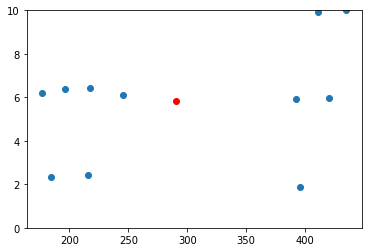

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt

tmp=data1[now]

axes = plt.gca()
axes.set_ylim([0,10])

tmp2=[[a[-2],a[-1]] for a in tmp['sensor_fusion'] if a[-1]>=0]
plt.scatter([a[-2] % max_s for a in tmp2], [a[-1] for a in tmp2])
plt.scatter([tmp['s']],[tmp['d']],color='red')
plt.show()

In [110]:
#get_best_line()

prev_x, prev_y, end_path_s, end_path_d, car_speed, ref_yaw, other_cars=get_variables(data1[now])
best_line=get_best_line(other_cars, line, end_path_s, car_speed)


end_path_d, l

possible:  [True, True, True]


(6.166722, 1)

In [198]:
VEHICLE_RADIUS=5

def total_accel_cost(traj):
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    a_s = to_equation(s_d_dot)
    
    d_dot = differentiate(d)
    d_d_dot = differentiate(d_dot)
    a_d = to_equation(d_d_dot)
    
    total_acc = 0
    dt = float(T) / 100.0
    for i in range(100):
        t = dt * i
        acc = a_s(t)+a_d(t)
        total_acc += abs(acc*dt)
    acc_per_second = total_acc / T
    
    return logistic(acc_per_second / EXPECTED_ACC_IN_ONE_SEC )
    
def max_accel_cost(traj):
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    a_s = to_equation(s_d_dot)
    
    d_dot = differentiate(d)
    d_d_dot = differentiate(d_dot)
    a_d = to_equation(d_d_dot)
    
    all_accs = [a_s(float(T)/100 * i)+a_d(float(T)/100 * i) for i in range(100)]
    max_acc = max(all_accs, key=abs)
    if abs(max_acc) > MAX_ACCEL: return 1
    else: return 0
    

def max_jerk_cost(traj):
    s, d, t = traj
    T=t
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    jerk = differentiate(s_d_dot)
    jerk_s = to_equation(jerk)
    
    d_dot = differentiate(d)
    d_d_dot = differentiate(d_dot)
    jerk = differentiate(d_d_dot)
    jerk_d = to_equation(jerk)
    
    
    all_jerks = [jerk_s(float(T)/100 * i)+jerk_d(float(T)/100 * i) for i in range(100)]
    max_jerk = max(all_jerks, key=abs)
    if abs(max_jerk) > MAX_JERK: return 1
    else: return 0

def total_jerk_cost(traj):
    s, d, t = traj
    T=t
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    jerk = differentiate(s_d_dot)
    jerk_s = to_equation(jerk)
    
    d_dot = differentiate(d)
    d_d_dot = differentiate(d_dot)
    jerk = differentiate(d_d_dot)
    jerk_d = to_equation(jerk)
    
    total_jerk = 0
    dt = float(T) / 100.0
    for i in range(100):
        t = dt * i
        j = abs(jerk_s(t))+abs(jerk_d(t))
        total_jerk += abs(j*dt)
    jerk_per_second = total_jerk / T
    return logistic(jerk_per_second / EXPECTED_JERK_IN_ONE_SEC )

def collision_cost(traj, other_vehicles):
    """
    Binary cost function which penalizes collisions.
    """
    
    nearest=9999
    T= traj[-1]
    q=traj[:2]


    for i in range(cnt_points):
        t=T*float(i)/cnt_points
        s=sum([q[0][j]*t**j for j in range(6)])
        d=sum([q[1][j]*t**j for j in range(6)])
   
        other_sd=[np.array(v.state_in(t))[[0,3]] for v in other_vehicles]
        tmp_nearst = min([((s1-s)**2+(d1-d)**2)**(0.5) for s1,d1 in other_sd])
        nearest=min([tmp_nearst, nearest])
        
    print (nearest, 2*VEHICLE_RADIUS)
    if nearest < 2*VEHICLE_RADIUS: return 1.0
    else : return 0.0

def buffer_cost(traj,  other_vehicles):
    """
    Penalizes getting close to other vehicles.
    """
    nearest=9999
    T= traj[-1]
    q=traj[:2]

    for i in range(cnt_points):
        t=T*float(i)/cnt_points
        s=sum([q[0][j]*t**j for j in range(6)])
        d=sum([q[1][j]*t**j for j in range(6)])
   
        other_sd=[np.array(v.state_in(t))[[0,3]] for v in other_vehicles]
        tmp_nearst = min([((s1-s)**2+(d1-d)**2)**(0.5) for s1,d1 in other_sd])
        nearest=min([tmp_nearst, nearest])
        
    print (nearest)
    return logistic(2*VEHICLE_RADIUS / nearest)

def cost_traj(traj,  other_vehicles):
    return [max_accel_cost(traj),total_accel_cost(traj),\
            max_jerk_cost(traj), total_jerk_cost(traj),\
            collision_cost(traj, other_vehicles),\
            buffer_cost(traj, other_vehicles)]

In [194]:
logistic(2*VEHICLE_RADIUS / 7)

0.21106497444117145

In [123]:
from ptg import JMT
from helpers import Vehicle
from constants import MAX_JERK, MAX_ACCEL

def gen_trajectories (car_speed, best_line, end_path_s, end_path_d):

    all_goals=[]
    delta_d=best_line*4+2-end_path_d

    vehicle = Vehicle([end_path_s,car_speed,0,end_path_d, 0,0])
    other_v= [Vehicle([a[0],a[1],0,a[2],0,0]) for a in other_cars]

    rt = [float(i)/2 for i in range(1,10)]

    start_s = [end_path_s, car_speed, 0]
    start_d = [end_path_d, 0, 0]

    for t in rt:
        for acc in [0]:
            target=vehicle.state_in(t)
            target[0]+=acc*t
            target[3]+=delta_d
            all_goals.append((target[:3],target[3:],t))

    trajectories = []
    for goal in all_goals:
        s_goal, d_goal, t = goal
        s_coefficients = JMT(start_s, s_goal, t)
        d_coefficients = JMT(start_d, d_goal, t)
        trajectories.append(tuple([s_coefficients, d_coefficients, t]))

    return trajectories

In [85]:
len(trajectories)

6

In [171]:
%matplotlib inline
import matplotlib.pyplot as plt

def draw_best_traj(trajectories, target_vehicle, other_vehicles):
    
    rr=[]
    for i in range(len(trajectories)):
        rr.append(cost_traj(trajectories[i], other_v))
        
    tmp= np.dot(np.array(rr), weights.T)
    best_traj=np.argmin(tmp)

    cnt_points=100
    points=np.zeros((cnt_points,2), dtype=np.float)

    for tri, res in enumerate(trajectories):
    
        q=res[:2]
        T=res[2]

        for i in range(cnt_points):
            t=T*float(i)/cnt_points

            s=sum([q[0][j]*t**j for j in range(6)])
            d=sum([q[1][j]*t**j for j in range(6)])
            points[i]=[s,d]

        if tri==best_traj:
            plt.scatter(points[:,0],points[:,1], color='red')
        else:
            plt.scatter(points[:,0],points[:,1], color='blue')

    
    for v in other_v:
        if v.state_in(0)[3] > 0 and v.state_in(0)[3]<4*3+2:
            for i in range(cnt_points):
                t=T*float(i)/cnt_points
                points[i]=np.array(v.state_in(t))[[0,3]]

            plt.scatter(points[:,0],points[:,1],color='green')


    plt.title('Line: %d best_line: %d' %  (round((end_path_d-2)/4), best_line))
    plt.show()
    
    return rr

In [172]:
other_v[0].state_in(0), other_cars[0]

([185.16133974678439, 10.842358649723593, 0, 6.1768590000000003, 0, 0],
 array([ 185.16133975,    6.176859  ,   10.84235865]))

possible:  [True, True, True]
45.8564113191
45.7734924339
45.6271314462
45.480773852
45.3344196841
45.1880689759
45.0417217611
44.8953780738
44.7490379487


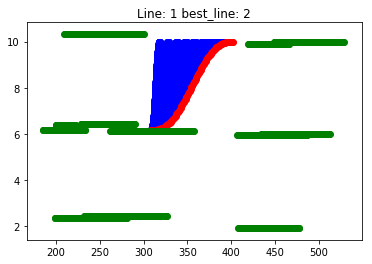

possible:  [True, True, True]
45.8210238196
45.8210238196
45.8210238196
45.8210238196
45.8210238196
45.8210238196
45.8210238196
45.8210238196
45.8210238196


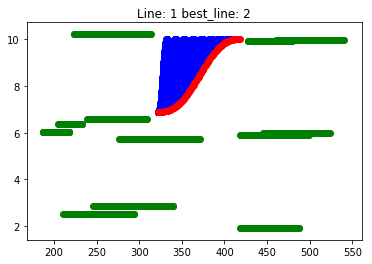

possible:  [True, True, True]
45.8398351744
45.8398351744
45.8398351744
45.8398351744
45.8398351744
45.8398351744
45.8398351744
45.8398351744
45.8398351744


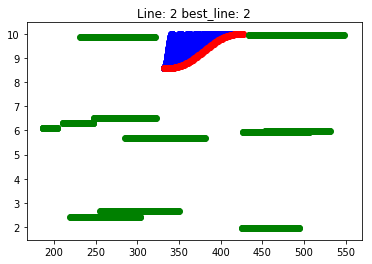

[ 680.16463194    2.051255     15.49586661] 678.6233 0
possible:  [False, True, True]
3.86553659783
4.14657929196
4.14657929196
4.14657929196
4.14657929196
4.14657929196
4.14657929196
4.14657929196
4.14657929196


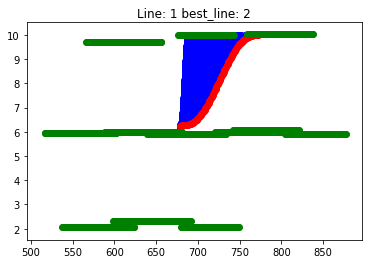

possible:  [True, True, True]
2.81716862526
4.33883948395
5.11076474788
5.11076474788
5.11076474788
5.11076474788
5.11076474788
5.11076474788
5.11076474788


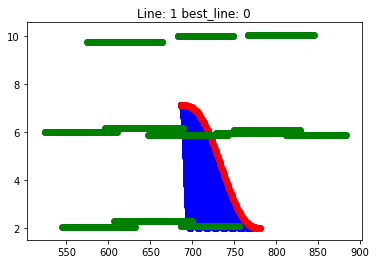

possible:  [True, True, True]
4.94274207368
6.42718164569
6.68785310797
6.68785310797
6.68785310797
6.68785310797
6.68785310797
6.68785310797
6.68785310797


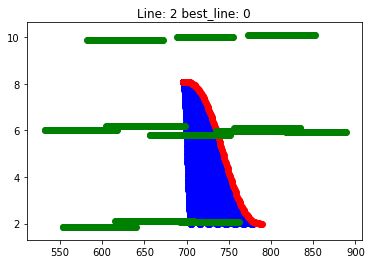

In [178]:
for i in range(6):
    now = needed[i*10]
    
    prev_x, prev_y, end_path_s, end_path_d, car_speed, ref_yaw, other_cars=get_variables(data1[now])
    best_line=get_best_line(other_cars, line, end_path_s, car_speed)


    end_path_d, l

    trajectories=gen_trajectories(car_speed, best_line, end_path_s, end_path_d)
    vehicle = Vehicle([end_path_s,car_speed,0,end_path_d, 0,0])
    other_v= [Vehicle([a[0],a[2],0,a[1],0,0]) for a in other_cars]


    res=draw_best_traj(trajectories,vehicle,  other_v)

In [174]:
res

[[1, 1.0, 1, 1.0, 0.0, 0.29448973391407973],
 [1, 1.0, 1, 1.0, 0.0, 0.2292368005878127],
 [1, 1.0, 1, 0.9999999982623664, 0.0, 0.2206004844057412],
 [1, 1.0, 1, 0.9996991673187774, 0.0, 0.2206004844057412],
 [1, 0.9999999999999982, 1, 0.9781690864806305, 0.0, 0.2206004844057412],
 [1, 0.9997564069162188, 1, 0.862747572190318, 0.0, 0.2206004844057412],
 [1, 0.89893569674378, 0, 0.6757080632524939, 0.0, 0.2206004844057412],
 [0, 0.6203690729610041, 0, 0.500611692551792, 0.0, 0.2206004844057412],
 [0, 0.5111801807216492, 0, 0.3682251646962711, 0.0, 0.2206004844057412]]

In [102]:
res=[]
for i in range(len(trajectories)):
    res.append(cost_traj(trajectories[i], vehicle, other_v))

In [175]:
import pandas as pd

df=pd.DataFrame(res,columns=['max_accel','total_accel','max_jerk','total_jerk','colistion','nearst'])

In [176]:
df

,max_accel,total_accel,max_jerk,total_jerk,colistion,nearst
0,1,1.000000,1,1.000000,0.0,0.294490
1,1,1.000000,1,1.000000,0.0,0.229237
2,1,1.000000,1,1.000000,0.0,0.220600
3,1,1.000000,1,0.999699,0.0,0.220600
4,1,1.000000,1,0.978169,0.0,0.220600
5,1,0.999756,1,0.862748,0.0,0.220600
6,1,0.898936,0,0.675708,0.0,0.220600
7,0,0.620369,0,0.500612,0.0,0.220600
8,0,0.511180,0,0.368225,0.0,0.220600


In [93]:
weights=np.array([1000,5,1000,20,1000,50])

In [96]:
np.argmin(np.dot(np.array(res), weights.T))

5

In [145]:
traj=trajectories[-1]
other_vehicles= other_v

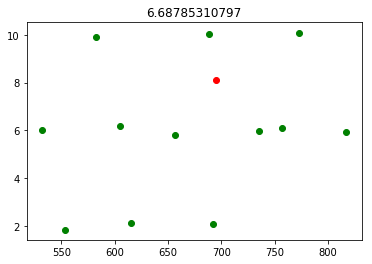

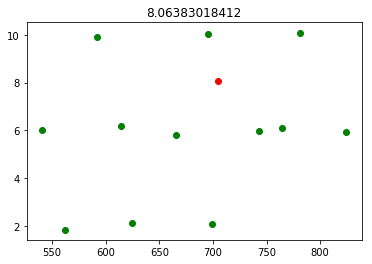

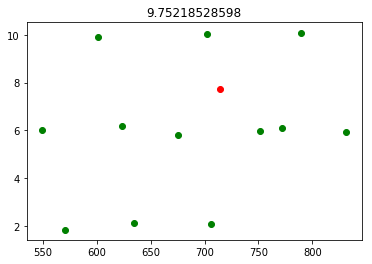

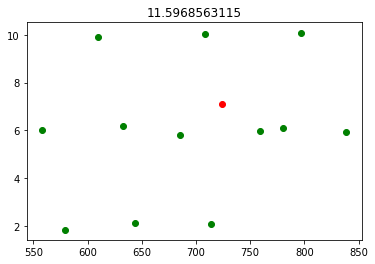

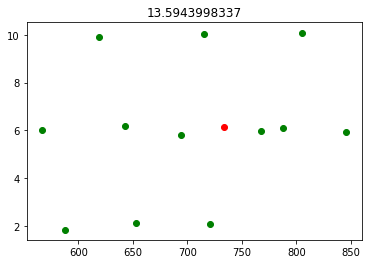

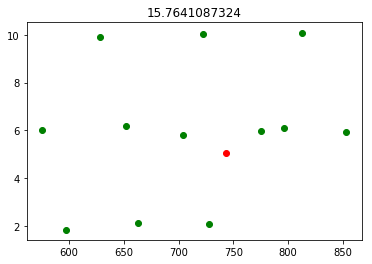

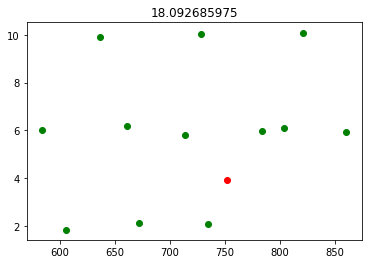

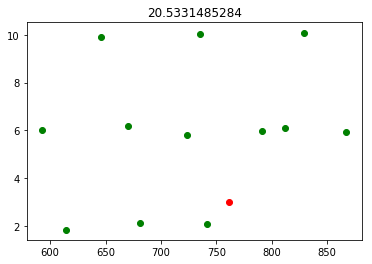

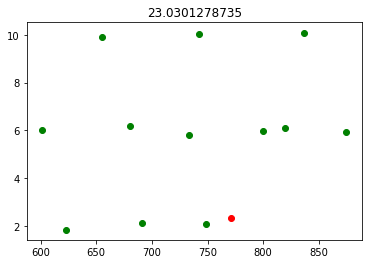

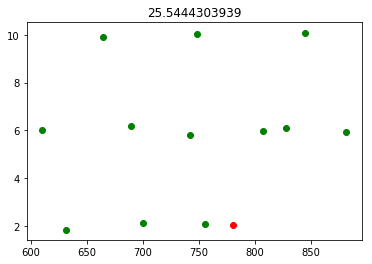

In [158]:
cnt_points = 10

nearest=9999

q=traj[:2]
T= traj[-1]


for i in range(cnt_points):
    t=T*float(i)/cnt_points
    s=sum([q[0][j]*t**j for j in range(6)])
    d=sum([q[1][j]*t**j for j in range(6)])

    other_sd=np.array([np.array(v.state_in(t))[[0,3]] for v in other_vehicles])
    tmp_nearst = ([((s1-s)**2+(d1-d)**2)**(0.5) for s1,d1 in other_sd])
    #nearest=min([tmp_nearst, nearest])
    
    plt.scatter(other_sd[:,0], other_sd[:,1], color='green')
    plt.scatter([s], [d], color='red')
    
    plt.title(str(min(tmp_nearst)))
    plt.show()


In [153]:
np.array(other_sd)

array([[ 817.22697205,    5.940462  ],
       [ 735.2724928 ,    5.966748  ],
       [ 582.72908313,    9.883787  ],
       [ 773.14969448,   10.08782   ],
       [ 656.19605752,    5.818699  ],
       [ 756.4507635 ,    6.085701  ],
       [ 692.52480835,    2.070863  ],
       [ 615.50407363,    2.116925  ],
       [ 531.97918779,    6.019144  ],
       [ 553.18423638,    1.85764   ],
       [ 604.95136726,    6.19493   ],
       [ 688.67449869,   10.01005   ]])

In [149]:
s,d

(402.04391617008787, 9.9581205369442038)

In [199]:
rr=[]
for i in range(len(trajectories)):
    rr.append(collision_cost(trajectories[i], other_v))

4.94274207368 10
6.42718164569 10
6.68785310797 10
6.68785310797 10
6.68785310797 10
6.68785310797 10
6.68785310797 10
6.68785310797 10
6.68785310797 10


In [200]:
rr

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]